In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import datetime
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.externals import joblib
from tqdm.notebook import tqdm

This notebook builds a gradient boosting regressor model. The model parameters are chosen using a gridsearch.

The best gradient boosting regressor model achieved a mean absolute error on the validation set of ~3. 

Other models were tested, for reference, a linear regression model achieved ~6 mae and a neural network with linear activation output layer achieved ~4 mae on the validation dataset.

In [2]:
sns.set(context='notebook', style='darkgrid')

## Load Data

In [3]:
y_train = pd.read_csv('data/y_train.csv', dtype='int64')
x_train = pd.read_csv('data/x_train.csv')

y_val = pd.read_csv('data/y_val.csv', dtype='int64')
x_val = pd.read_csv('data/x_val.csv')

## Carry out gridsearch to find best parameters

In [4]:
# create dict of parameters to search
search_params = {
    'n_estimators': [90, 95, 105],
    'learning_rate': [0.055, 0.05, 0.04],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [4, 5, 6],
    'loss': ['huber', 'ls'],
    }

# search all combinations of parameters
model = GradientBoostingRegressor()
best_mse = 100
for p in tqdm(ParameterGrid(search_params)):
    model.set_params(**p)
    model.fit(x_train, y_train.values.flatten())
    # record best performing on val set
    val_mse = mean_squared_error(y_val, model.predict(x_val))
    if val_mse < best_mse:
        best_mse = val_mse
        best_grid = p

print("Best MSE: %0.3f" % best_mse)
print("Best Grid:", best_grid)


Best MSE: 36.286
Best Grid: {'learning_rate': 0.05, 'loss': 'ls', 'max_depth': 4, 'min_samples_leaf': 6, 'n_estimators': 90}


In [26]:
# create model using best parameters
model = GradientBoostingRegressor(learning_rate=best_grid['learning_rate'],
                                  loss=best_grid['loss'],
                                  max_depth=best_grid['max_depth'],
                                  min_samples_leaf=best_grid['min_samples_leaf'],
                                  n_estimators=best_grid['n_estimators'])
model.fit(x_train, y_train.values.flatten())

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=90, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

## Create Save Folder

In [27]:
model_id = 'gboost'

In [28]:
def save_folder(model_id):
    """Create save folder and return the path.
    
    # Arguments
        model_id: identifier for model
    """
    date_time = datetime.datetime.now()
    date_now = str(date_time.date())
    time_now = str(date_time.time()).split('.')[0]
    sf = "model/" + date_now + "_" + time_now + "_" + model_id
    if not os.path.isdir(sf):
        os.makedirs(sf)
    return sf

In [29]:
# create save folder
sf = save_folder(model_id)

## Save Model

In [30]:
joblib.dump(model, sf + '/model.pkl') 

['model/2020-02-12_16:10:06_gboost/model.pkl']

## Check and Save MAE, MSE

In [31]:
# do predictions
pred_train = model.predict(x_train)
pred_val = model.predict(x_val)

In [32]:
# calculate errors
val_mse = mean_squared_error(y_val, model.predict(x_val))
val_mae = mean_absolute_error(y_val, model.predict(x_val))
train_mse = mean_squared_error(y_train, model.predict(x_train))
train_mae =mean_absolute_error(y_train, model.predict(x_train))
print('Train Mean Absolute Error: ' + str(train_mae))
print('Train Mean Squared Error: ' + str(train_mse))
print('Validation Mean Absolute Error: ' + str(val_mae))
print('Validation Mean Squared Error: ' + str(val_mse))

Train Mean Absolute Error: 3.1889633432437785
Train Mean Squared Error: 30.975228583064293
Validation Mean Absolute Error: 3.3087566461541713
Validation Mean Squared Error: 36.28643835369501


In [33]:
# save metrics in txt in model folder
with open(sf + "/metrics.txt", "a") as f:
    print('Train Mean Absolute Error: ' + str(train_mae), file=f)
    print('Train Mean Squared Error: ' + str(train_mse), file=f)
    print('Validation Mean Absolute Error: ' + str(val_mae), file=f)
    print('Validation Mean Squared Error: ' + str(val_mse), file=f)

## Plot Actual vs Predictions

In [34]:
def plot_AvsP(actual, predictions, save_folder, title):
    """Plot and save actual vs predicted volumes.
    
    # Arguments
        actual: actual volumes.
        predictions:predicted volumes.
        save_folder: path to save plot.
        title: heading for plot
    """
    plt.figure(figsize=(10,10))
    sns.scatterplot(x=list(actual.values), y=list(predictions))
    plt.xlabel('True Volume')
    plt.xlim([0,100])
    plt.ylabel('Predicted Volume')
    plt.ylim([0,100])
    plt.title(title)
    plt.savefig(save_folder)
    plt.show()

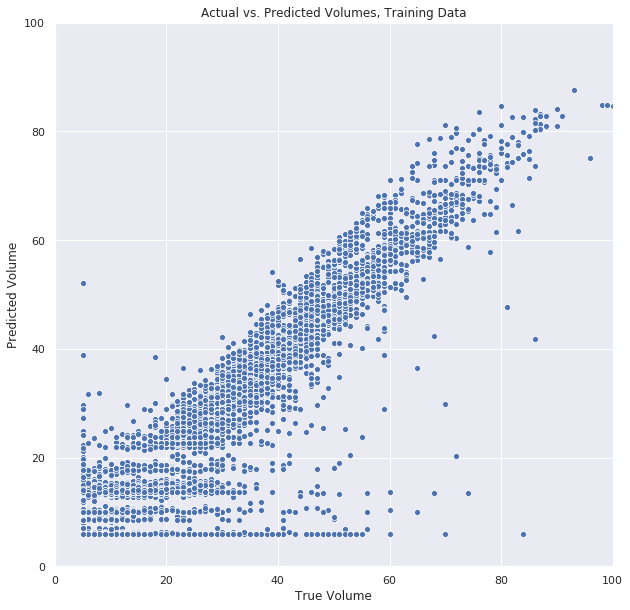

In [35]:
plot_AvsP(y_train, pred_train, sf+'/train_actual_vs_predict',
          'Actual vs. Predicted Volumes, Training Data')

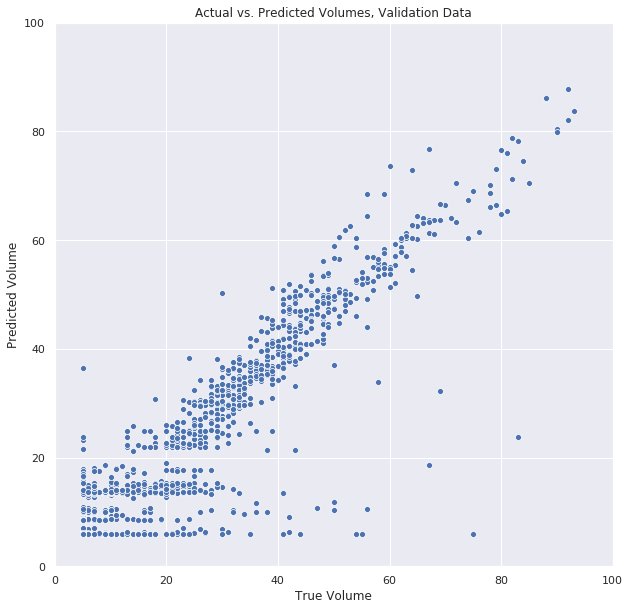

In [36]:
plot_AvsP(y_val, pred_val, sf+'/val_actual_vs_predict',
          'Actual vs. Predicted Volumes, Validation Data')

## Plot Error Distribution

In [37]:
def plot_error_dist(error, save_folder):
    """Plot and save distribution of volumes errors.
    
    # Arguments
        error: predction volumes - actual volumes
        save_folder: path to save plot.
    """
    plt.figure(figsize=(8,8))
    sns.distplot(error, kde=False)
    plt.xlabel('Volume Error')
    plt.ylabel('Count')
    plt.title('Errors, Validation Data')
    plt.savefig(save_folder + '/error_dist.png')
    plt.show()

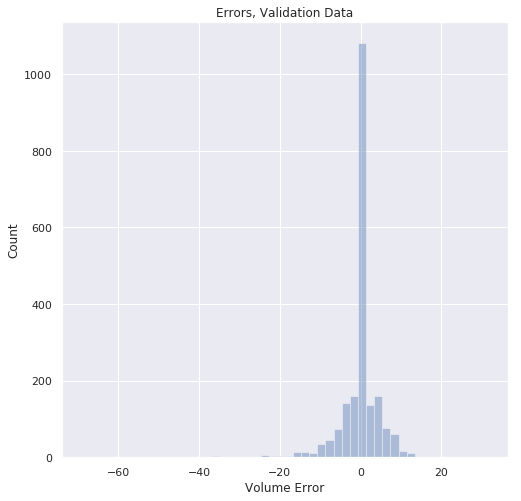

In [38]:
error = pred_val - y_val.values.flatten()
plot_error_dist(error, sf)